In [1]:
# Dependencies
%matplotlib inline
import json
import tweepy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import Twitter API Keys
from config import consumer_key, consumer_secret, access_token, access_token_secret

# Hide warning messages in notebook
import warnings
warnings.filterwarnings('ignore')

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [2]:
#List of organizations
organizations = ["BBC", "CBS", "CNN", "Fox", "nytimes"]
labels = ["BBC", "CBS", "CNN", "Fox", "NYT"]
# Lists to hold sentiments
source_list = []
compound_list = []
positive_list = []
negative_list = []
neutral_list = []
date_list = []
text_list = []
ind_list = []

#data frame
df = pd.DataFrame()

In [3]:
# Loop through all tweets
for org_ind in range(len(organizations)):
    ind_ = 0
    org="@"+organizations[org_ind]
    public_tweets = api.user_timeline(org, count=100)
    for tweet in public_tweets:
        # Run Vader Analysis on each tweet
        compound = analyzer.polarity_scores(tweet["text"])["compound"]
        pos = analyzer.polarity_scores(tweet["text"])["pos"]
        neu = analyzer.polarity_scores(tweet["text"])["neu"]
        neg = analyzer.polarity_scores(tweet["text"])["neg"]

        # Add each value to the appropriate array
        source_list.append(labels[org_ind])
        compound_list.append(compound)
        positive_list.append(pos)
        negative_list.append(neg)
        neutral_list.append(neu) 
        date_list.append(tweet['created_at'])
        text_list.append(tweet["text"])
        ind_list.append(ind_)
        ind_ +=1
df["source"]  =  source_list
df["date"] = date_list
df["text"] = text_list
df["compound"] = compound_list
df["positive"] = positive_list
df["negative"] = negative_list
df["neutral"] = neutral_list
df["ind"] = ind_list

#save the result
df.to_csv("TheResult.csv", index=False, header=True)

In [4]:
#convert date
from datetime import datetime
def plot_title():
    d=df["date"][0][4:10] + " " + df["date"][0][-4:]
    datetime_object = datetime.strptime(d, '%b %d %Y')
    s = str(datetime_object.month) + "/" + str(datetime_object.day) + "/" + str(datetime_object.year)
    return (s)

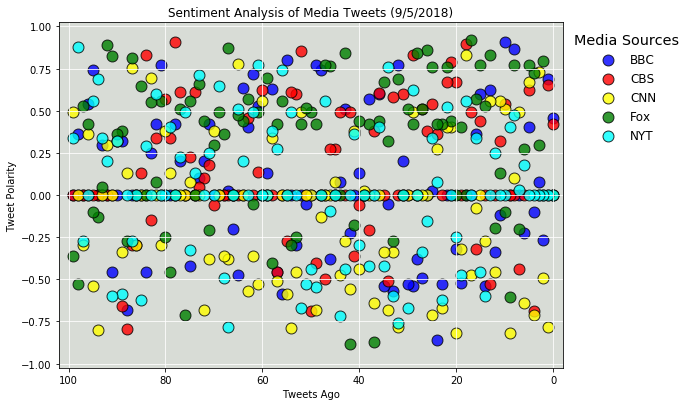

In [5]:
#generate plots
color_list = ["blue","red","yellow","green","cyan"]
fig = plt.figure(figsize=(10,6))  # create a figure object
ax = fig.add_subplot(1,1,1)  # create an axes object in the figure
ax.set_position([0.1,0.1,0.7,0.8])
ax.set_facecolor('xkcd:light grey')

for i in range(len(labels)):
    x=df.loc[df["source"]==labels[i],"ind"].tolist()
    y=df.loc[df["source"]==labels[i],"compound"].tolist()
    col = color_list[i]
    ax.scatter(x,y,label=labels[i],edgecolors="black",s=120, alpha=0.8, color=col)
   
plt.xlim(102, -2)
plt.ylim(-1.025, 1.025)
plt.xlabel('Tweets Ago')
plt.ylabel('Tweet Polarity')
plt.title("Sentiment Analysis of Media Tweets ({0})".format(plot_title()))
plt.grid(color="white")
ax.grid(True)
leg = plt.legend(fontsize='large', bbox_to_anchor=(1, 1), frameon=False)
leg.set_title("Media Sources", prop = {'size':'x-large'})
ax.set_facecolor('xkcd:light grey')
plt.savefig("Sentiment Analysis of Media Tweets.png")
fig.show()

In [6]:
df.head(5)

,source,date,text,compound,positive,negative,neutral,ind
0,BBC,Wed Sep 05 13:06:03 +0000 2018,One town. One year. Two generations. Welcome t...,0.4588,0.167,0.000,0.833,0
1,BBC,Wed Sep 05 12:03:04 +0000 2018,.@Nadia_Sapphire was fat-shamed when she first...,0.6908,0.275,0.000,0.725,1
2,BBC,Wed Sep 05 11:38:45 +0000 2018,RT @BBCR1: IT'S HAPPENING!!\n\n@ArianaGrande i...,-0.2695,0.095,0.172,0.733,2
3,BBC,Wed Sep 05 11:00:09 +0000 2018,"Boeing says Asia needs 240,000 pilots over nex...",0.0772,0.058,0.000,0.942,3
4,BBC,Wed Sep 05 10:16:29 +0000 2018,The family of Rachael Bland has confirmed that...,-0.1027,0.119,0.134,0.746,4


In [7]:
compound_sum = pd.DataFrame(df.groupby('source')["compound"].mean()).reset_index()
compound_sum

,source,compound
0,BBC,0.066591
1,CBS,0.136477
2,CNN,-0.080870
3,Fox,0.275202
4,NYT,0.033479


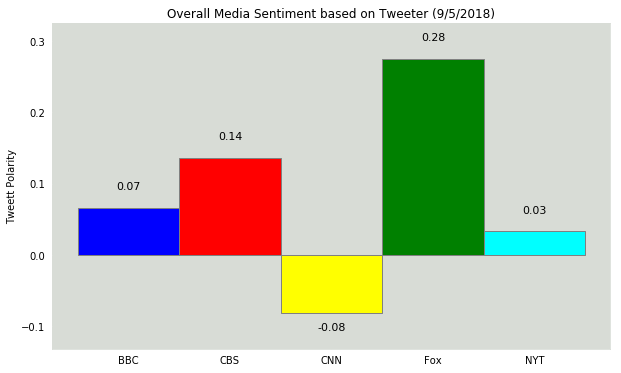

In [8]:
#generate text
def generateText(xList, yList, delta):
    for i in range(len(xList)):
        if yList[i] < 0:
            y_ = yList[i]-delta/2
        else:
            y_ = yList[i]+delta/2
        plt.text(y=y_,x=xList[i],s=str(round(yList[i],2)),color= "black",size=11,horizontalalignment='center'  )
        
    
# create figure and subplot
fig, ax = plt.subplots(figsize=(10,6))
a = plt.bar(compound_sum.iloc[:,0].tolist(),compound_sum.iloc[:,1].tolist(),1,bottom=[0,0,0,0,0],align='center',color=color_list,alpha=1,edgecolor ="gray")
ax.set_facecolor('xkcd:light grey') 
plt.setp(ax.spines.values(), color='xkcd:light grey')
plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='white')
plt.grid(False)

# determine the step of y-axis scale 
delta = (compound_sum.iloc[:,1].max()-compound_sum.iloc[:,1].min())/7

# create space for the text values
plt.ylim((compound_sum.iloc[:,1].min()-delta,compound_sum.iloc[:,1].max()+delta))

generateText(compound_sum.iloc[:,0].tolist(),compound_sum.iloc[:,1].tolist(),delta)

# other settings
plt.title("Overall Media Sentiment based on Tweeter ({})".format(plot_title()))
plt.ylabel("Tweett Polarity")
# Save the Figure
fig.savefig("Summary Bar Graph.png")
# Show the Figure
fig.show()